## 1. 데이터 준비

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import io, os
import pytesseract
from PIL import Image
from pytesseract import Output
 
dir_path = os.getenv('HOME')+'/aiffel/ocr_python/'
file_list = os.listdir(dir_path)
file_list

['image04.png',
 'image02.png',
 'image06.png',
 'image05.png',
 'image01.png',
 'image08.png',
 'image03.png',
 'image07.png']

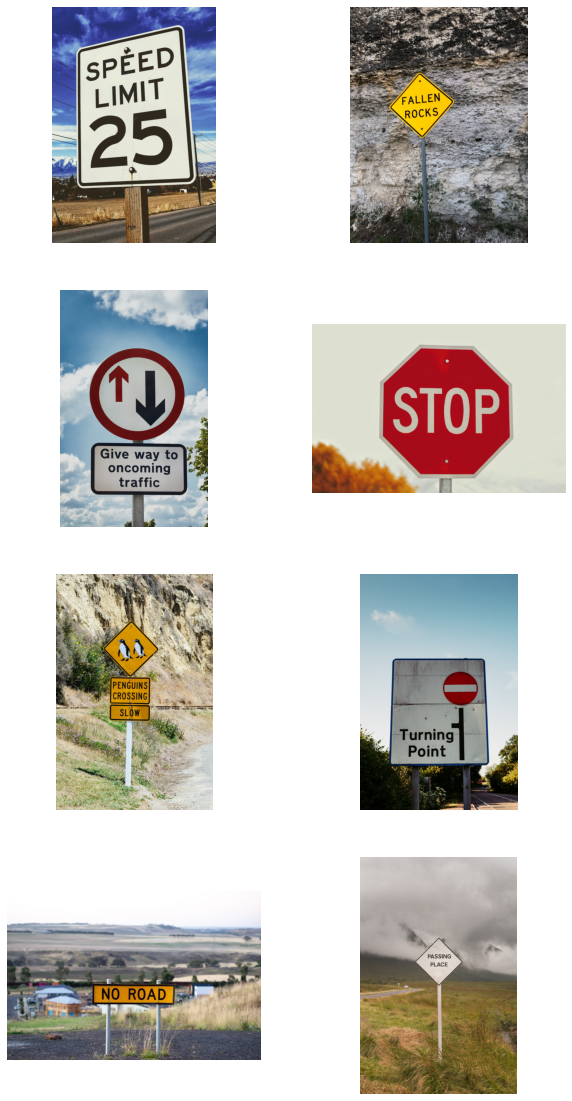

In [2]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,20))

for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path + file_list[i])
    ax.imshow(image)
    ax.axis("off")
plt.show()

## 2. keras-ocr

In [3]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
images = [keras_ocr.tools.read(os.path.join(dir_path, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(dir_path, file)]) for file in file_list]

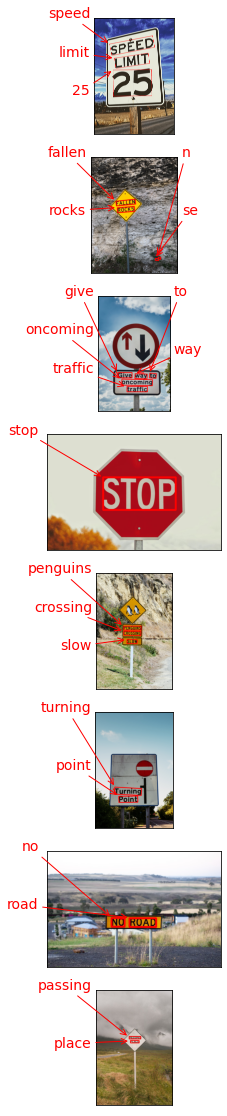

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 3. Tesseract

In [6]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
   
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [7]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(dir_path, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[image04.png]
Cannot recognize characters from image04.png
[image02.png]
Cannot recognize characters from image02.png
[image06.png]
Cannot recognize characters from image06.png
[image05.png]
Cannot recognize characters from image05.png
[image01.png]
Cannot recognize characters from image01.png
[image08.png]
Cannot recognize characters from image08.png
[image03.png]
Cannot recognize characters from image03.png
[image07.png]
Cannot recognize characters from image07.png


## 4. Google OCR API

In [12]:
def detect_text(path):
    """Detects text in the file."""
    
    from google.cloud import vision
    import io
    
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [13]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(dir_path, file))
    print()


[image04.png]


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #388767945414 by visiting https://console.developers.google.com/billing/enable?project=388767945414 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry. [links {
  description: "Google developers console billing"
  url: "https://console.developers.google.com/billing/enable?project=388767945414"
}
, reason: "BILLING_DISABLED"
domain: "googleapis.com"
metadata {
  key: "consumer"
  value: "projects/388767945414"
}
metadata {
  key: "service"
  value: "vision.googleapis.com"
}
]

## 프로젝트를 마치며

이번 프로젝트는 OCR을 활용하여 텍스트 이미지를 인식하는 모델을 구현하는 것이 목적이었다. 데이터는 8개의 도로 표지판을 활용하였다. 총 세가지 모델을 활용해보려 했으나 google ocr API를 사용하는 과정에서 오류가 발생하였다. 결제된 상태에서 작업을 진행해야 하는 듯 해서 결제를 하려고 했으나 무료 크래딧을 제공받지 못하여 이 문제가 해결되면 사용할 수 있을 것 같다. 따라서 이번 프로젝트에서는 두 가지 모델에 대한 결과물만을 분석해보았다. 

먼저 keras-ocr은 대부분의 텍스트 이미지를 인식하였다. 총 8가지 이미지 중 7개의 이미지를 완벽하게 인식하였다. 한 가지 이미지는 배경을 텍스트로 인식하는 문제가 발생하였다. 이를 해결하기 위해서는 이미지에 대한 전처리 과정이 필요해보인다.

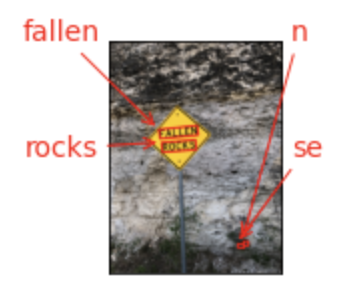

Tesseract를 사용했을 때에는 8개의 이미지를 모두 인식하지 못하는 상황이 발생하였다. keras-ocr보다 당연히 성능은 낮을 것이라 예상은 했지만 하나의 텍스트도 인식하지 못할 줄은 몰랐다. detection, recognition 모두 진행되지 못하는 것으로 보였다.